In [147]:
import cv2
import matplotlib.pyplot as pl
from os import listdir
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
%matplotlib inline

#Обучение базы словаря
С каждого изображения я решил брать по 100 дескрипторов для характерных точек с наивысшим откликом

In [70]:
base_dir = 'base/'
descriptors = []
for filename in listdir(base_dir):
    img_gray = cv2.cvtColor(cv2.imread(base_dir + filename),cv2.COLOR_BGR2GRAY)
    _, des = cv2.SIFT().detectAndCompute(img_gray, None)
    descriptors.append(des)

In [71]:
descriptors = np.concatenate(descriptors)
descriptors.shape

(91939, 128)

In [72]:
n_clusters=2000
clf = KMeans(n_clusters=n_clusters)
clf.fit(descriptors)
clf.cluster_centers_

array([[ 21.68518519,  56.11111111,  69.88888889, ...,  10.38888889,
         14.90740741,  19.64814815],
       [  4.93103448,  12.86206897,  20.65517241, ...,  35.34482759,
         31.13793103,  13.86206897],
       [ 37.37837838,  48.72972973,  26.08108108, ...,  16.13513514,
         17.83783784,  11.48648649],
       ..., 
       [ 21.22857143,  23.31428571,  32.65714286, ...,  25.82857143,
         16.25714286,  11.88571429],
       [ 27.56      ,  66.92      ,  57.68      , ...,   6.44      ,
         14.24      ,  11.16      ],
       [ 34.92857143,  59.0952381 ,  27.69047619, ...,  15.19047619,
         16.16666667,  12.66666667]])

In [76]:
import pickle
with open('bow-dict', 'wb') as f:
    pickle.dump(clf.cluster_centers_, f)

#Вычисление дескрипторов Bag-Of-Words

In [82]:
dictionary = clf.cluster_centers_

In [94]:
bag_of_words_dict = {}

for filename in listdir(base_dir):
    img_gray = cv2.cvtColor(cv2.imread(base_dir + filename),cv2.COLOR_BGR2GRAY)
    _, des = cv2.SIFT().detectAndCompute(img_gray, None)
    
    bag_of_words_vector = np.zeros(n_clusters)
    for descriptor in des:
        neighbour_idx = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')\
        .fit(dictionary)\
        .kneighbors(descriptor)[1][0][0]
        bag_of_words_vector[neighbour_idx] += 1
    bag_of_words_dict[filename] = bag_of_words_vector

In [109]:
# take sqrt from each element and apply L2-normalization
bag_of_words_dict_n = {}
for base_img in bag_of_words_dict:
    bag_of_words_dict_n[base_img] = normalize(np.vectorize(lambda x: x**0.5)(bag_of_words_dict[base_img]))[0]

In [150]:
# save Bag-Of-Words dict
with open('bow_dict', 'wb') as f:
    pickle.dump(bag_of_words_dict_n, f)

#Поиск

In [112]:
queries_dir = 'queries/'
queries_des = []
for filename in listdir(queries_dir):
    img_gray = cv2.cvtColor(cv2.imread(queries_dir + filename),cv2.COLOR_BGR2GRAY)
    _, des = cv2.SIFT().detectAndCompute(img_gray, None)
    
    bag_of_words_vector = np.zeros(n_clusters)
    for descriptor in des:
        neighbour_idx = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')\
        .fit(dictionary)\
        .kneighbors(descriptor)[1][0][0]
        bag_of_words_vector[neighbour_idx] += 1
    queries_des.append(normalize(np.vectorize(lambda x: x**0.5)(bag_of_words_vector))[0])

In [139]:
# Map: query image filename -> image descriptor
queries_map = {}
for i in xrange(len(queries_des)):
    queries_map[listdir(queries_dir)[i]] = queries_des[i]

In [126]:
responses = []
for query in queries_des:
    min_distance = -1
    neighbor_img = ''
    for image in bag_of_words_dict_n:
        new_distance = np.dot(query, bag_of_words_dict_n[image])
        if min_distance == -1 or min_distance < new_distance:
            neighbor_img = image
            min_distance = new_distance
    responses.append(neighbor_img)

In [127]:
responses

['ucid00217.tif',
 'ucid00817.tif',
 'ucid01314.tif',
 'ucid00019.tif',
 'ucid01204.tif',
 'ucid00124.tif',
 'ucid00301.tif']

In [121]:
listdir(queries_dir)

['ucid00217.tif',
 'ucid00817.tif',
 'ucid01314.tif',
 'ucid00019.tif',
 'ucid01204.tif',
 'ucid00124.tif',
 'ucid00301.tif']

Как видим, точность поисковой выдачи <b>7/7</b>. Стоит заметить однако, что картинки тем БЛИЖЕ, чем БОЛЬШЕ скалярное произведение их дескрипторов Bag-Of-Words (в нашем случае чем ближе к 1). Это связано с тем, что величина их скалярного произведения тем больше, чем больше число общих дескрипторов из базиса Bag-Of-Words. (Замечание: чтобы это пространство действительно могло называться пространством, стоит переопределить скалярное произведение как dot'(a, b) = 1/dot(a, b), чтобы выполнялось правило треугольника)

#Поиск с RANSAC

In [136]:
def find_images(query, bow_dict, count=10):
    images = []
    distances = []
    for image in bow_dict:
        images.append(image)
        distances.append(np.dot(query, bow_dict[image]))
    return [x[0] for x in sorted(zip(images, distances), key=lambda x: -x[1])[:count]]

Рассмотрим топ-10 поисковой выдачи для картинки 'ucid00217.tif'

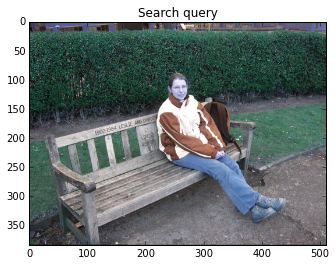

In [261]:
image_fileaname = 'ucid00217.tif'
pl.imshow(cv2.imread(base_dir + image_fileaname))
pl.title('Search query')

In [262]:
search_results = find_images(queries_map[image_fileaname], bag_of_words_dict_n)
search_results

['ucid00217.tif',
 'ucid00218.tif',
 'ucid01315.tif',
 'ucid01314.tif',
 'ucid00354.tif',
 'ucid00355.tif',
 'ucid01316.tif',
 'ucid00357.tif',
 'ucid00215.tif',
 'ucid00356.tif']

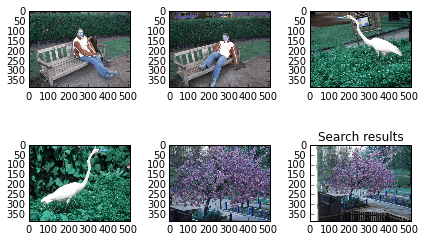

In [263]:
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + search_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + search_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + search_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + search_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + search_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + search_results[5]))
pl.tight_layout()
pl.title('Search results')

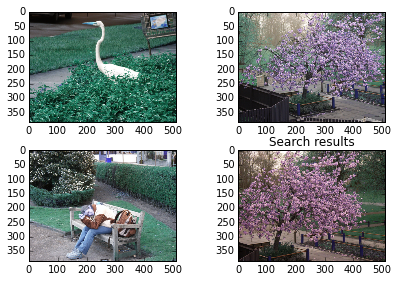

In [266]:
pl.subplot(2, 2, 1)
pl.imshow(cv2.imread(base_dir + search_results[6]))
pl.subplot(2, 2, 2)
pl.imshow(cv2.imread(base_dir + search_results[7]))
pl.subplot(2, 2, 3)
pl.imshow(cv2.imread(base_dir + search_results[8]))
pl.subplot(2, 2, 4)
pl.imshow(cv2.imread(base_dir + search_results[9]))
pl.tight_layout()
pl.title('Search results')

Как видно, в топ-10 без применения RANSAC попало три соответствующих картинки (2 на первом месте запроса, и одна на предпоследнем). Попробуем отранжировать поисковый результат, примененив RANSAC

In [268]:
def get_search_ranks(query_image_filename, search_result_filenames):    
    search_rank = []
    for i in xrange(len(search_result_filenames)):
        img_gray = cv2.cvtColor(cv2.imread(base_dir + search_result_filenames[i]),cv2.COLOR_BGR2GRAY)
        kp_1, des_1 = cv2.SIFT().detectAndCompute(img_gray, None)

        img_gray = cv2.cvtColor(cv2.imread(base_dir + query_image_filename),cv2.COLOR_BGR2GRAY)
        kp_0, des_0 = cv2.SIFT().detectAndCompute(img_gray, None)

        des_0, des_1 = np.float32(des_0), np.float32(des_1)
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        matches = bf.match(des_0, des_1)
        src_pts = np.float32([ kp_0[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_1[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

        _, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 10.)
        search_rank.append(sum(mask))
    return search_rank

get_search_ranks(image_fileaname, search_results)

[1656, 329, 14, 16, 12, 13, 13, 12, 14, 12]

Как видим, первые два изображения из поискового запроса имеют очень высокий по сравнению с остальными ранг, но предпоследнее изображение (похожее на поисковое) имеет сравнительно невысокий ранг. Визуализируем отранжированный поисковый запрос (первые шесть результатов)

In [269]:
def range_search_results(query_image_filename, search_result_filenames):
    ranks = get_search_ranks(image_fileaname, search_results)
    return [x[0] for x in sorted(zip(search_result_filenames, ranks), key=lambda x: -x[1])]

ranged_results = range_search_results(image_fileaname, search_results)

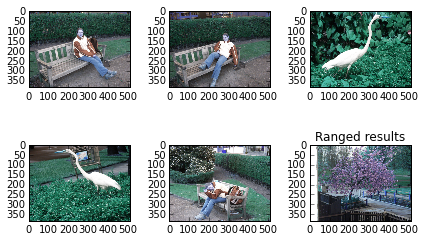

In [270]:
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + ranged_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + ranged_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + ranged_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + ranged_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + ranged_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + ranged_results[5]))
pl.tight_layout()
pl.title('Ranged results')

Как видим, результаты запроса немного улучшились. 9-я картинка из поискового результата (с девушкой) сместилась на 5-е место. Применим этот подход для остальных запросов

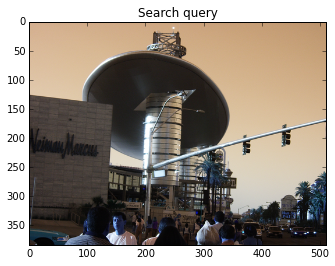

In [284]:
image_filename = listdir(queries_dir)[1]
pl.imshow(cv2.imread(base_dir + image_filename))
pl.title('Search query')

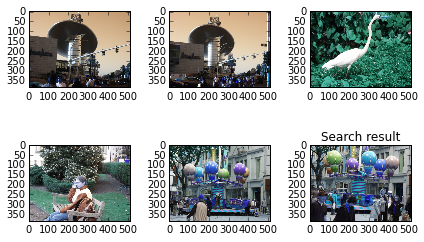

In [285]:
search_results = find_images(queries_map[image_filename], bag_of_words_dict_n)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + search_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + search_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + search_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + search_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + search_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + search_results[5]))
pl.tight_layout()
pl.title('Search result')

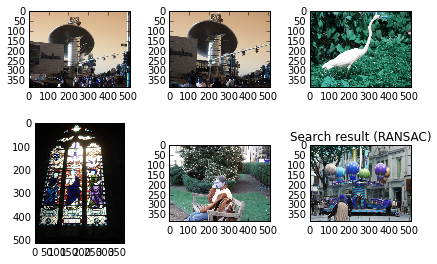

In [286]:
ranged_results = range_search_results(image_filename, search_results)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + ranged_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + ranged_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + ranged_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + ranged_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + ranged_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + ranged_results[5]))
pl.tight_layout()
pl.title('Search result (RANSAC)')

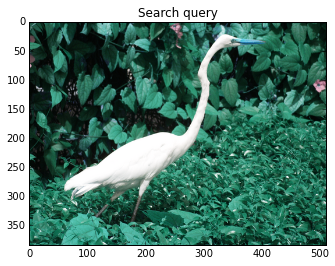

In [287]:
image_filename = listdir(queries_dir)[2]
pl.imshow(cv2.imread(base_dir + image_filename))
pl.title('Search query')

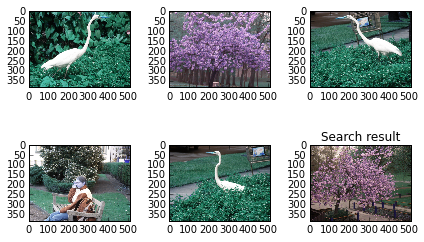

In [289]:
search_results = find_images(queries_map[image_filename], bag_of_words_dict_n)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + search_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + search_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + search_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + search_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + search_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + search_results[5]))
pl.tight_layout()
pl.title('Search result')

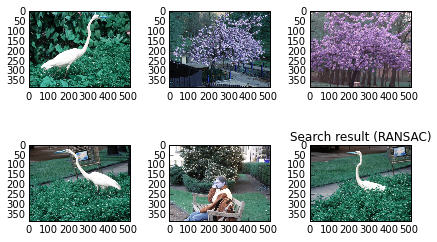

In [290]:
ranged_results = range_search_results(image_filename, search_results)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + ranged_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + ranged_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + ranged_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + ranged_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + ranged_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + ranged_results[5]))
pl.tight_layout()
pl.title('Search result (RANSAC)')

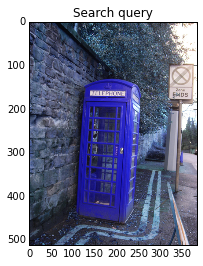

In [291]:
image_filename = listdir(queries_dir)[3]
pl.imshow(cv2.imread(base_dir + image_filename))
pl.title('Search query')

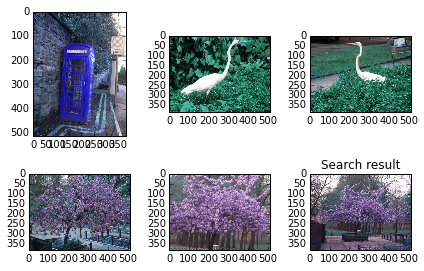

In [292]:
search_results = find_images(queries_map[image_filename], bag_of_words_dict_n)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + search_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + search_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + search_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + search_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + search_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + search_results[5]))
pl.tight_layout()
pl.title('Search result')

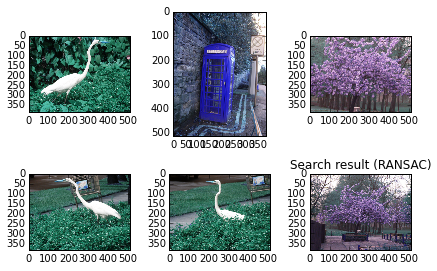

In [293]:
ranged_results = range_search_results(image_filename, search_results)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + ranged_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + ranged_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + ranged_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + ranged_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + ranged_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + ranged_results[5]))
pl.tight_layout()
pl.title('Search result (RANSAC)')

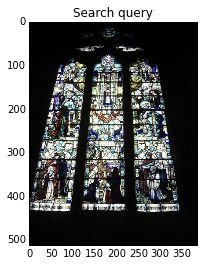

In [294]:
image_filename = listdir(queries_dir)[4]
pl.imshow(cv2.imread(base_dir + image_filename))
pl.title('Search query')

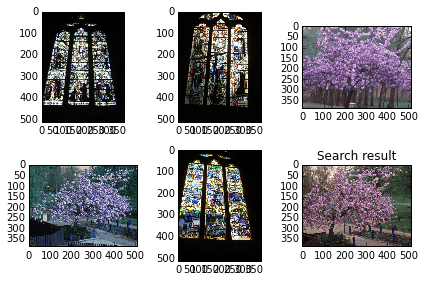

In [295]:
search_results = find_images(queries_map[image_filename], bag_of_words_dict_n)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + search_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + search_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + search_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + search_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + search_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + search_results[5]))
pl.tight_layout()
pl.title('Search result')

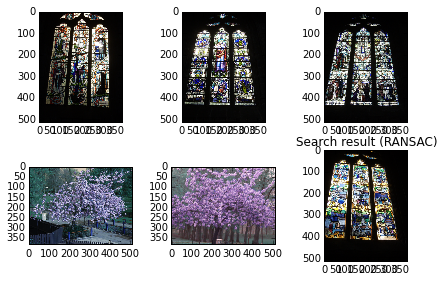

In [296]:
ranged_results = range_search_results(image_filename, search_results)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + ranged_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + ranged_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + ranged_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + ranged_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + ranged_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + ranged_results[5]))
pl.tight_layout()
pl.title('Search result (RANSAC)')

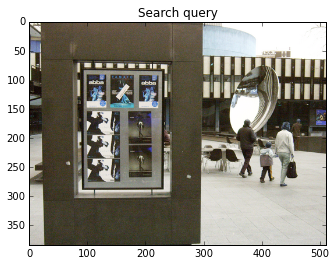

In [297]:
image_filename = listdir(queries_dir)[5]
pl.imshow(cv2.imread(base_dir + image_filename))
pl.title('Search query')

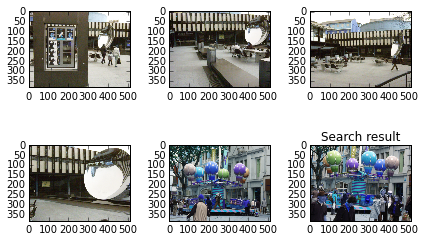

In [298]:
search_results = find_images(queries_map[image_filename], bag_of_words_dict_n)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + search_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + search_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + search_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + search_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + search_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + search_results[5]))
pl.tight_layout()
pl.title('Search result')

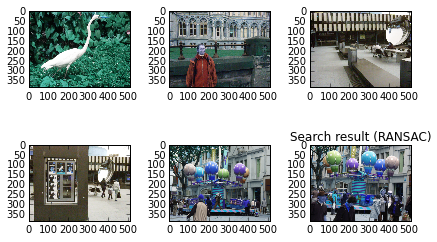

In [300]:
ranged_results = range_search_results(image_filename, search_results)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + ranged_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + ranged_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + ranged_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + ranged_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + ranged_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + ranged_results[5]))
pl.tight_layout()
pl.title('Search result (RANSAC)')

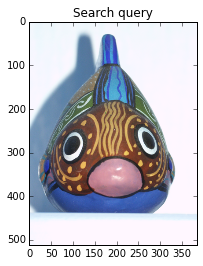

In [301]:
image_filename = listdir(queries_dir)[6]
pl.imshow(cv2.imread(base_dir + image_filename))
pl.title('Search query')

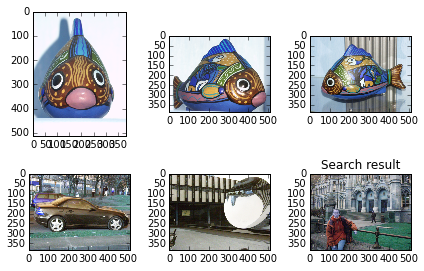

In [302]:
search_results = find_images(queries_map[image_filename], bag_of_words_dict_n)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + search_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + search_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + search_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + search_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + search_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + search_results[5]))
pl.tight_layout()
pl.title('Search result')

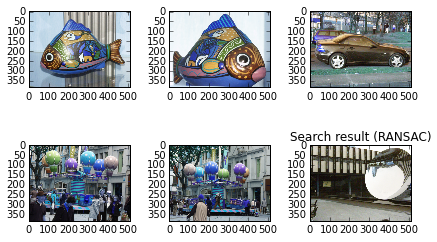

In [304]:
ranged_results = range_search_results(image_filename, search_results)
pl.subplot(2, 3, 1)
pl.imshow(cv2.imread(base_dir + ranged_results[0]))
pl.subplot(2, 3, 2)
pl.imshow(cv2.imread(base_dir + ranged_results[1]))
pl.subplot(2, 3, 3)
pl.imshow(cv2.imread(base_dir + ranged_results[2]))
pl.subplot(2, 3, 4)
pl.imshow(cv2.imread(base_dir + ranged_results[3]))
pl.subplot(2, 3, 5)
pl.imshow(cv2.imread(base_dir + ranged_results[4]))
pl.subplot(2, 3, 6)
pl.imshow(cv2.imread(base_dir + ranged_results[5]))
pl.tight_layout()
pl.title('Search result (RANSAC)')

Как можно увидеть, RANSAC чуть улучшил поисковую выдачу, но далеко не на всех картинках (например, результат последней выдачи с ранжированием RANSAC оказался хуже исходной). Тем не менее, на первой картинке (девушка, сидящая на скамейке) было чётко видно, что схожие картинки имели заметно большее число единиц в mask (1600 vs 12-14)